<a href="https://colab.research.google.com/github/BitKnitting/FitHome_Analysis/blob/master/notebooks/FitHome_Leaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FitHome Leaks
This notebook reads in data that has been collected from a FitHome monitor during the learning process and determins the amount of Leaking Electricity.

In [0]:
# @title Upload data
!curl 'https://fithome-9ebbd.firebaseio.com/flower-09282019/readings.json?print=pretty' > fithome_flower-09282019.json  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3253k  100 3253k    0     0  1257k      0  0:00:02  0:00:02 --:--:-- 1256k


In [0]:
# @title Read JSON

import pandas as pd

df_needs_reshape = pd.read_json("fithome_flower-09282019.json", "r", encoding="utf8")

In [0]:
# @title Reshape

df_reshaped = df_needs_reshape.T
df_reshaped.head()

,I,P
2019-10-11 20:46:35,5.039,572.1619
2019-10-11 20:46:40,5.059,575.0713
2019-10-11 20:46:45,5.032,572.7318
2019-10-11 20:46:50,5.037,573.5241
2019-10-11 20:46:56,5.042,573.4320


In [0]:
# The datetime is in UTC time.  We are in the US/Pacific Timezone....
df_reshaped.index = df_reshaped.index.tz_localize('UTC').tz_convert('US/Pacific')
print('First Date: {}   Last Date: {}'.format(df_reshaped.index.min(),df_reshaped.index.max()))

First Date: 2019-10-11 13:46:35-07:00   Last Date: 2019-10-15 11:03:35-07:00


In [0]:
# @title Interesting Data Stats
df_reshaped.describe()

,I,P
count,55398.000000,55398.000000
mean,7.297679,789.778153
std,5.112335,574.627802
min,1.775000,157.689600
25%,3.150000,331.186850
50%,5.448000,573.609050
75%,10.729000,1190.879750
max,43.649000,4820.673000


In [0]:
import plotly.graph_objects as go

In [0]:
# @title Interactive Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_reshaped.index,y=df_reshaped['P'],name='Power',line_color='deepskyblue'))
fig.update_layout(title_text='Power Readings',
                  xaxis_rangeslider_visible=True)
fig.show()

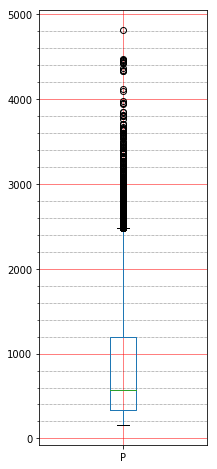

In [0]:
# @title Box Plot
ax = df_reshaped['P'].plot.box(figsize=(3,8))
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

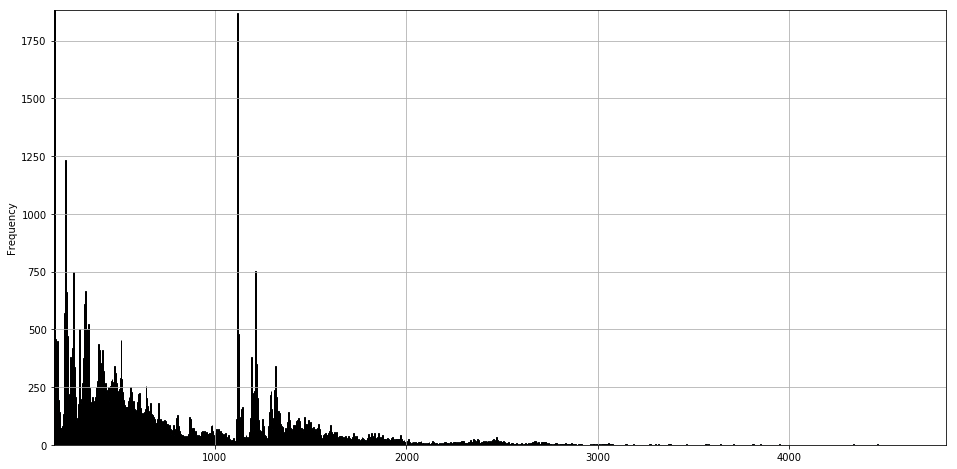

In [0]:
 # @title Histogram Distribution
 df_reshaped['P'].plot.hist(bins=1000, grid=True, edgecolor='k',figsize=(16,8)).autoscale(enable=True, axis='both', tight=True)


In [0]:
# @title Determine amount Leaking
df_bins = df_reshaped['P'].value_counts(bins=1000)

left_bin = df_bins.index[0].left
right_bin = df_bins.index[0].right

amount_leaking = int(round((right_bin + left_bin) / 2))
print('Amount of leakage: {}w\n'.format(amount_leaking))
print('Highest Frequency bins: \n{}'.format(df_bins.head(10)))

Amount of leakage: 165w

Highest Frequency bins: 
(162.353, 167.016]      1883
(1118.264, 1122.927]    1871
(218.308, 222.971]      1232
(1113.601, 1118.264]     937
(1211.524, 1216.187]     752
(260.275, 264.938]       747
(320.894, 325.557]       666
(222.971, 227.634]       661
(316.231, 320.894]       610
(213.645, 218.308]       570
Name: P, dtype: int64


In [0]:
# @title kWh
kwH = amount_leaking/1000*24*365
print('kwH in a year: {}'.format(kwH))
# .1036 / kWh in Kirkland
yearly_cost = kwH*.1036
print("yearly cost: ${}".format(yearly_cost))

kwH in a year: 1445.4
yearly cost: $149.74344


# kWh


In [0]:
# @title Get samples to have the same time delta.
df_5s = df_5s = df_reshaped.resample(rule='5S').mean()

In [0]:
df_hourly_count = df_5s['2019-10-12']['P'].resample(rule='H').count()
df_hourly_count

2019-10-12 00:00:00-07:00    703
2019-10-12 01:00:00-07:00    699
2019-10-12 02:00:00-07:00    702
2019-10-12 03:00:00-07:00    685
2019-10-12 04:00:00-07:00    702
2019-10-12 05:00:00-07:00    704
2019-10-12 06:00:00-07:00    698
2019-10-12 07:00:00-07:00    699
2019-10-12 08:00:00-07:00    702
2019-10-12 09:00:00-07:00    703
2019-10-12 10:00:00-07:00    690
2019-10-12 11:00:00-07:00    700
2019-10-12 12:00:00-07:00    703
2019-10-12 13:00:00-07:00    700
2019-10-12 14:00:00-07:00    703
2019-10-12 15:00:00-07:00    696
2019-10-12 16:00:00-07:00    695
2019-10-12 17:00:00-07:00    701
2019-10-12 18:00:00-07:00    705
2019-10-12 19:00:00-07:00    703
2019-10-12 20:00:00-07:00    700
2019-10-12 21:00:00-07:00    697
2019-10-12 22:00:00-07:00    688
2019-10-12 23:00:00-07:00    693
Freq: H, Name: P, dtype: int64

## Per Hour
We have the samples in 5 second intervals.

Energy in kWh = sum(power)/1000 * T(5 seconds)/3600 (seconds/hour)

In [0]:
daily_kWh = int(round(df_5s['2019-10-12']['P'].sum()/1000*5/3600))
print('Daily kWh: {} kWh'.format(daily_kWh))

Daily kWh: 25 kWh


## Per Day
Bummer.  There isn't a day that has the same number of samples.  This is because the monitor keeps going off line.

In [0]:
df_daily_count = df_5s['P'].resample(rule='D').count()
print('Number of samples in each day: \n{}'.format(df_daily_count))


Number of samples in each day: 
2019-10-11 00:00:00-07:00     7163
2019-10-12 00:00:00-07:00    16771
2019-10-13 00:00:00-07:00    10307
2019-10-14 00:00:00-07:00    13361
2019-10-15 00:00:00-07:00     7709
Freq: D, Name: P, dtype: int64


In [0]:
type(df_daily_count)

pandas.core.series.Series

In [0]:
df_daily_kWh = df_5s["P"].resample('D').mean()
df_daily_kWh

2019-10-11 00:00:00-07:00     484.372580
2019-10-12 00:00:00-07:00    1081.394716
2019-10-13 00:00:00-07:00     899.407017
2019-10-14 00:00:00-07:00     558.332985
2019-10-15 00:00:00-07:00     692.755222
Freq: D, Name: P, dtype: float64